In [1]:
#Diabetic Retinopathy
# Dataset - https://www.kaggle.com/competitions/diabetic-retinopathy-detection/data

### Imports

In [2]:
import pandas as pd 
from sklearn.model_selection import train_test_split as datasetSplit
import numpy as np 
import os

import torch
import torch.nn as nn
import torchvision 
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from sklearn.metrics import cohen_kappa_score
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

from torch.optim import lr_scheduler


### Hyperparameters

In [3]:
# Dataset paths containing all the images and image labels
dataset_images = "Data/images_650/"
dataset_labels = "Data/trainLabels.csv"

BATCHSIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.0001

WEIGHT_DECAY = 0.0005 #L2 Norm on the model weights
NUM_EPOCHS = 100
NUM_WORKERS = 0 
CHECKPOINT_FOLDER = "Checkpoints/"
CHECKPOINT_FILE = "EfNetB3_v1.pth.tar"
PATIENCE = 3 #for early stopping

PIN_MEMORY = True
SAVE_MODEL = True
LOAD_MODEL = True

INPUT_IMAGE_WIDTH = 120
INPUT_IMAGE_HEIGHT = 120

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/EfNetB3_v1")

### Dataset

In [4]:
print(f'{len(os.listdir(dataset_images))} images found in the dataset_images') 

35126 images found in the dataset_images


#### Train Val Split

In [5]:
inputs = np.array(pd.read_csv(dataset_labels)["image"])
targets = np.array(pd.read_csv(dataset_labels)["level"])
print(f"{len(inputs)} images and {len(targets)} targets found")

35126 images and 35126 targets found


In [6]:
train_inputs, val_inputs, train_labels, val_labels = datasetSplit(inputs,targets,test_size= 0.11,random_state=47,shuffle=True)

In [7]:
print(f"Dataset Train Size: {len(train_inputs)}, Dataset Test Size:{len(val_inputs)}")

Dataset Train Size: 31262, Dataset Test Size:3864


#### Dataset Class

In [8]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self,inputs,targets,data_transforms=None):
        self.inputs = inputs
        self.targets = torch.from_numpy(targets.astype(np.float32))
        self.data_transforms = data_transforms
        self.n_samples = len(inputs)
        
    def __getitem__(self,index):
        img_path = self.inputs[index]
        img = Image.open(dataset_images+img_path+".jpeg")
        img = np.array(img) #Albumenations takes nd.array as input
        # img = torch.from_numpy(img.astype(np.float32))
        img_label = self.targets[index]
        if self.data_transforms:
            img = self.data_transforms(image=img)["image"]
            img.type(torch.float32)
        return img, img_label, img_path
        
    def __len__(self):
        return self.n_samples


#### Data Transforms

In [9]:
train_transforms = A.Compose([
    A.Resize(width=INPUT_IMAGE_WIDTH+30,height=INPUT_IMAGE_HEIGHT+30),
    A.RandomCrop(width=INPUT_IMAGE_WIDTH,height=INPUT_IMAGE_HEIGHT),
    A.Normalize(mean=[0.3199, 0.2240, 0.1609],std=[0.3020, 0.2183, 0.1741],max_pixel_value = 255.0), 
    ToTensorV2()
    ])

#Test with more transformations

val_transforms = A.Compose([
    A.Resize(width=INPUT_IMAGE_WIDTH,height=INPUT_IMAGE_HEIGHT),
    A.Normalize(mean=[0.3199, 0.2240, 0.1609],std=[0.3020, 0.2183, 0.1741],max_pixel_value = 255.0), 
    ToTensorV2()
    ])

#### Dataset Loader

In [10]:
train_dataset = DiabeticRetinopathyDataset(train_inputs,train_labels,data_transforms=train_transforms)
val_dataset = DiabeticRetinopathyDataset(val_inputs,val_labels,data_transforms=val_transforms)

In [11]:
train_loader =DataLoader(train_dataset,batch_size=BATCHSIZE,shuffle=True,num_workers=NUM_WORKERS)
val_loader =DataLoader(val_dataset,batch_size=BATCHSIZE,shuffle=False,num_workers=NUM_WORKERS)

#### Having a look at first batch

In [12]:
train_iter = iter(train_loader)
first_batch = train_iter.next()
batch_images, batch_labels, batch_files = first_batch

In [13]:
batch_images.shape

torch.Size([64, 3, 120, 120])

In [14]:
batch_labels.shape

torch.Size([64])

##### Visualise Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


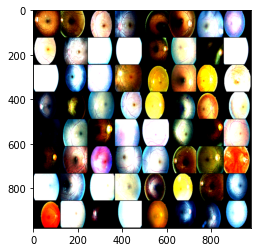

In [15]:
batch_images_grid = torchvision.utils.make_grid(batch_images,nrow=8)
writer.add_image("Retina Images",batch_images_grid)
writer.close()

plt.imshow(batch_images_grid.permute(1, 2, 0))

### Utility Functions

In [16]:
def make_prediction(model,dataloader,output_csv="submission.csv"):
    all_preds = []
    file_names = []
    # total_loss = 0.0
    model.eval() #set the model to evaluation state

    for inputs, labels, names in enumerate(dataloader):
        inputs = inputs.to(DEVICE)
        with torch.no_grad():
            outs = model(inputs)
            _, batch_preds = torch.max(outs,1)
            all_preds.append(batch_preds.cpu().numpy())
            # batch_loss = nn.CrossEntropyLoss(outs,labels)
            # total_loss += batch_loss
            # batch_kappa = 
            file_names.append(names)

    # epoch_loss = total_loss/len(dataloader)
    df = pd.DataFrame({"image":file_names,"level":np.concatenate(all_preds, axis=0)})
    df.to_csv(output_csv,index=False)
    model.train() #Set the model back to training phase

def calculate_accuracy(model,dataloader,epoch_num):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [],[]
    correct_predictions = 0
    num_samples = 0
    dataiter = tqdm(dataloader)
    for batchID, (inputs, labels, names) in enumerate(dataiter):
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(DEVICE)

        with torch.no_grad():
            outs = model(inputs)
            _, batch_preds = torch.max(outs,1)
            batch_loss = loss_func(outs,labels)
            correct_predictions += (batch_preds==labels).sum().item()
            num_samples += outs.shape[0]

            all_preds.append(batch_preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            total_loss += batch_loss.item()
        dataiter.set_postfix(loss=batch_loss.item())
            
            

    model.train()
    epoch_acc = 100.0*correct_predictions/num_samples
    epoch_loss = total_loss/len(dataloader)
    # print(f"Epoch Accuracy: {accuracy:.2f}%. Predicted {correct_predictions} correcctly out of {num_samples} images!")
    all_preds = np.concatenate(all_preds,axis=0,dtype=np.int64)
    all_labels = np.concatenate(all_labels,axis=0,dtype=np.int64)
    kappa = cohen_kappa_score(all_labels,all_preds,weights='quadratic')
    print(f"Epoch (Val): {epoch_num}, Loss= {epoch_loss}, Accuracy= {epoch_acc}, Kappa= {kappa}")
    writer.add_scalar('val_loss',epoch_loss,global_step=epoch_num)
    writer.add_scalar('val_acc',epoch_acc,global_step=epoch_num)
    writer.add_scalar('val_kappa',kappa,global_step=epoch_num)
    writer.close()
    return epoch_acc, kappa 

            
def save_checkpoint(state_dicts):
    torch.save(state_dicts,CHECKPOINT_FOLDER+CHECKPOINT_FILE)

def load_checkpoint(checkpoint_file,model,optimiser,learning_rate):
    checkpoint = torch.load(checkpoint_file)
    model.load_state_dict(checkpoint["state_dict"])
    optimiser.load_state_dict(checkpoint["optimiser"])

    for params in optimiser.param_groups:
        params["lr"] = learning_rate
    


### PreProcess


### Design the Model

#### Model

In [17]:
model = EfficientNet.from_pretrained("efficientnet-b3")
in_features = model._fc.in_features
model._fc = nn.Linear(in_features,5) #
model = model.to(DEVICE)

Loaded pretrained weights for efficientnet-b3


#### Loss Function, Optmiser

In [18]:
loss_func = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE,weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()
lr_scheduler1 = lr_scheduler.StepLR(optimiser,step_size=7,gamma=0.1)

### Training

In [19]:
def train_epoch(model,dataloader,optimiser,scheduler,loss_func,scaler,epoch_num):
    total_loss = 0.0
    dataiter = tqdm(dataloader)
    correct_predictions = 0
    num_samples = 0
    all_preds, all_labels = [],[]
    for batch_num,(inputs,labels,filenames) in enumerate(dataiter):
        inputs = inputs.to(DEVICE)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(DEVICE)

        if batch_num%40 == 0 and epoch_num%10==0 : #visualising few batch images (after transforms) 
            writer.add_image("Batch_"+str(batch_num),torchvision.utils.make_grid(inputs,nrow=8))
            writer.close()

        #forward pass
        with torch.cuda.amp.autocast():
            outs = model(inputs)
            _, batch_preds = torch.max(outs,1)
            # print(outs.shape,labels.shape) 
            batch_loss = loss_func(outs,labels)

        
        total_loss += batch_loss.item()
        correct_predictions += (batch_preds==labels).sum().item()
        num_samples += outs.shape[0]
        all_preds.append(batch_preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

        #backward step
        optimiser.zero_grad()
        scaler.scale(batch_loss).backward()
        scaler.step(optimiser)
        # optimiser.step()
        scaler.update()
        dataiter.set_postfix(loss=batch_loss.item())

    epoch_loss = total_loss/len(dataloader)
    epoch_acc = 100.0*correct_predictions/num_samples
    all_preds = np.concatenate(all_preds,axis=0,dtype=np.int64)
    all_labels = np.concatenate(all_labels,axis=0,dtype=np.int64)
    scheduler.step()

    kappa = cohen_kappa_score(all_labels,all_preds,weights='quadratic')
    print(f"Epoch (Train): {epoch_num}, Loss= {epoch_loss}, Accuracy= {epoch_acc}, Kappa= {kappa}")
    writer.add_scalar('training_loss',epoch_loss,global_step=epoch_num)
    writer.add_scalar('training_acc',epoch_acc,global_step=epoch_num)
    writer.add_scalar('training_kappa',kappa,global_step=epoch_num)
    writer.close()
    

In [20]:
# Check if it is working for one epoch
# train_epoch(model,train_loader,optimiser,loss_func,scaler,0)

In [21]:
def trainModel(model,trainloader,valloader,optimiser,lr_scheduler1,loss_func,epochs):
    
    checkpoint_stuff = {"state_dict":model.state_dict() ,"optimiser":optimiser.state_dict()}
    best_kappa = 0.0
    best_epoch = 0
    es = 0 #early stopper

    for epoch in range(epochs):

        #Train Phasenb m, bn,
        model.train()
        
        train_epoch(model,train_loader,optimiser,lr_scheduler1,loss_func,scaler,epoch)
        
        #Validation Phase
        model.eval()
        epoch_acc, kappa  = calculate_accuracy(model,val_loader,epoch)
        
        #Early stopping and checkpoints
        if (kappa > best_kappa) :
            best_kappa = kappa
            es = 0 
            checkpoint_stuff = {"state_dict":model.state_dict() ,"optimiser":optimiser.state_dict()}
            best_epoch = epoch
            print(f"Checkpoint Saved at {best_epoch}")
        else :
            es += 1
            print(f"Model performance has not improved in this epoch. Patience: {es}/{PATIENCE}")
            if es>PATIENCE:
                print(f"Early Stopping with {best_kappa} at Epoch {best_epoch}")
                break


    model.load_state_dict(checkpoint_stuff["state_dict"]) #load the best model
    if SAVE_MODEL:
        save_checkpoint(checkpoint_stuff)
        # print("Checkpoint - Model Saved at {best_epoch}")
    return model #return the trained model
    
    




In [22]:
trainedModel = trainModel(model,train_loader,val_loader,optimiser,lr_scheduler1,loss_func,40)

100%|██████████| 489/489 [04:33<00:00,  1.79it/s, loss=0.608]


Epoch (Train): 0, Loss= 0.8586835028691282, Accuracy= 72.61851449043567, Kappa= 0.1472502113036287


100%|██████████| 61/61 [00:26<00:00,  2.30it/s, loss=0.902]


Epoch (Val): 0, Loss= 0.8327332158557704, Accuracy= 71.972049689441, Kappa= 0.4115324346711693
Checkpoint Saved at 0


100%|██████████| 489/489 [04:25<00:00,  1.84it/s, loss=0.58] 


Epoch (Train): 1, Loss= 0.7111397974330224, Accuracy= 75.92604439895081, Kappa= 0.4482600255410043


100%|██████████| 61/61 [00:26<00:00,  2.33it/s, loss=0.856]


Epoch (Val): 1, Loss= 0.7555856729140047, Accuracy= 74.71532091097309, Kappa= 0.502419168591224
Checkpoint Saved at 1


100%|██████████| 489/489 [04:25<00:00,  1.85it/s, loss=0.53] 


Epoch (Train): 2, Loss= 0.6625735596401316, Accuracy= 77.28872113108567, Kappa= 0.536436287049924


100%|██████████| 61/61 [00:26<00:00,  2.29it/s, loss=0.872]


Epoch (Val): 2, Loss= 0.7271277665114794, Accuracy= 76.08695652173913, Kappa= 0.516495539156226
Checkpoint Saved at 2


100%|██████████| 489/489 [04:24<00:00,  1.85it/s, loss=0.419]


Epoch (Train): 3, Loss= 0.6206748989584012, Accuracy= 78.75375855671422, Kappa= 0.5949187212137448


100%|██████████| 61/61 [00:26<00:00,  2.34it/s, loss=0.976]


Epoch (Val): 3, Loss= 0.7375166582279518, Accuracy= 75.6728778467909, Kappa= 0.5175556879984915
Checkpoint Saved at 3


100%|██████████| 489/489 [04:22<00:00,  1.86it/s, loss=0.47] 


Epoch (Train): 4, Loss= 0.5866819740804426, Accuracy= 79.41590429275158, Kappa= 0.6262802505929218


100%|██████████| 61/61 [00:26<00:00,  2.34it/s, loss=1.04] 


Epoch (Val): 4, Loss= 0.7546424597013192, Accuracy= 73.93892339544513, Kappa= 0.5329556802166246
Checkpoint Saved at 4


100%|██████████| 489/489 [04:22<00:00,  1.86it/s, loss=0.507]


Epoch (Train): 5, Loss= 0.5487087073379743, Accuracy= 80.58985349625743, Kappa= 0.6677621954865807


100%|██████████| 61/61 [00:26<00:00,  2.33it/s, loss=0.788]


Epoch (Val): 5, Loss= 0.7421661038867763, Accuracy= 74.5600414078675, Kappa= 0.5514317240486399
Checkpoint Saved at 5


100%|██████████| 489/489 [04:22<00:00,  1.86it/s, loss=0.597]


Epoch (Train): 6, Loss= 0.5077720077856918, Accuracy= 81.78299532979337, Kappa= 0.7038499808741079


100%|██████████| 61/61 [00:25<00:00,  2.35it/s, loss=0.9]  


Epoch (Val): 6, Loss= 0.7941715258066772, Accuracy= 72.17908902691511, Kappa= 0.5413728584279602
Model performance has not improved in this epoch. Patience: 1/3


100%|██████████| 489/489 [04:22<00:00,  1.86it/s, loss=0.685]


Epoch (Train): 7, Loss= 0.41340084684772727, Accuracy= 85.00415840317318, Kappa= 0.7754062087162312


100%|██████████| 61/61 [00:26<00:00,  2.34it/s, loss=1.05] 


Epoch (Val): 7, Loss= 0.7557862210469167, Accuracy= 75.85403726708074, Kappa= 0.5608286131339957
Checkpoint Saved at 7


100%|██████████| 489/489 [04:23<00:00,  1.86it/s, loss=0.393]


Epoch (Train): 8, Loss= 0.3852541551816683, Accuracy= 85.82624272279445, Kappa= 0.7896977963560072


100%|██████████| 61/61 [00:26<00:00,  2.31it/s, loss=1.05] 


Epoch (Val): 8, Loss= 0.7879875062919054, Accuracy= 75.18115942028986, Kappa= 0.5603884537807922
Model performance has not improved in this epoch. Patience: 1/3


100%|██████████| 489/489 [04:22<00:00,  1.86it/s, loss=0.191]


Epoch (Train): 9, Loss= 0.3589095275216795, Accuracy= 86.92981894952338, Kappa= 0.8096183438700311


100%|██████████| 61/61 [00:25<00:00,  2.35it/s, loss=1.07] 


Epoch (Val): 9, Loss= 0.8124582327780177, Accuracy= 74.71532091097309, Kappa= 0.558152608294915
Model performance has not improved in this epoch. Patience: 2/3


100%|██████████| 489/489 [04:29<00:00,  1.81it/s, loss=0.25] 


Epoch (Train): 10, Loss= 0.34280140643105184, Accuracy= 87.40643592860341, Kappa= 0.8224655048280176


100%|██████████| 61/61 [00:26<00:00,  2.34it/s, loss=1.09] 


Epoch (Val): 10, Loss= 0.8383681485887433, Accuracy= 74.45652173913044, Kappa= 0.5522528456391598
Model performance has not improved in this epoch. Patience: 3/3


100%|██████████| 489/489 [04:23<00:00,  1.86it/s, loss=0.446]


Epoch (Train): 11, Loss= 0.3263430513731054, Accuracy= 88.18373744482119, Kappa= 0.8336561429768927


100%|██████████| 61/61 [00:26<00:00,  2.32it/s, loss=1.13] 


Epoch (Val): 11, Loss= 0.8670934624359256, Accuracy= 74.4824016563147, Kappa= 0.5529974630001833
Model performance has not improved in this epoch. Patience: 4/3
Early Stopping with 0.5608286131339957 at Epoch 7


: 